画像 (ケース番号: 3)


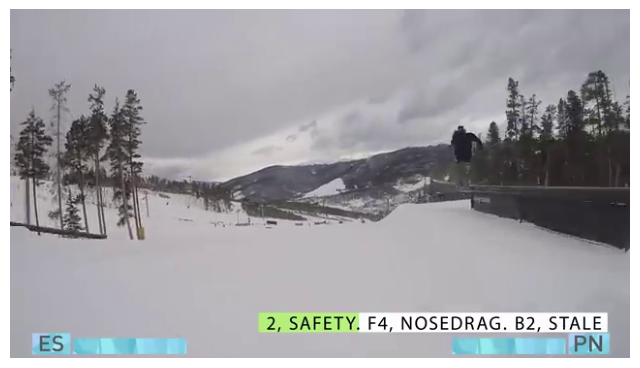

In [1]:
from slvsh_tr.example import load_examples
import cv2
import matplotlib.pyplot as plt

examples = load_examples()
example = examples[2]
image = example.get_image()
case_number = example.get_case_number()

# BGRからRGBに変換 (OpenCVはデフォルトでBGRを使用)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 画像とcase_numberを表示
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
print(f'画像 (ケース番号: {case_number})')
plt.show()

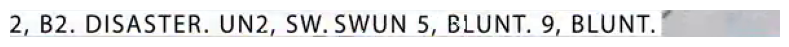

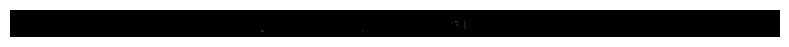

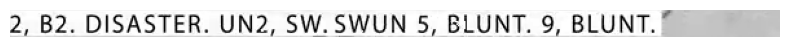

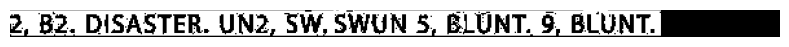

テキスト領域: (0, 0, 503, 20)


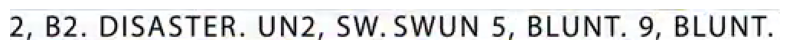

'2, B2. DISASTER. UN2. SW.SWUN 5, BLUNT. 9, BLUNT.'

In [2]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitning4Recognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_red_and_green(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）- 明るい赤のみ
        lower_red2 = np.array([170, 100, 100])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, mask_red2)
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY) #真っ白の四角を対象にする
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.05 and h > height * 0.9:
                # 右端または左端にアラインされているか確認
                if x < width * 0.05 or x + w > width * 0.95:
                    text_regions.append((x, y, w, h))
        
        if text_regions:
            # 幅が最大のものを選択
            return max(text_regions, key=lambda r: r[2])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_red_and_green(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. /"'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            return ""
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitning4Recognizer(debug=True)
model.infer(examples[31].get_image())

In [3]:
from slvsh_tr import eval
import pandas as pd

model = TesseractFindRectWhitning4Recognizer()
result = eval(model)

# 評価結果をDataFrameに変換
df = pd.DataFrame([r.dump() for r in result])
df.mean(numeric_only=True)

例の評価中: 100%|██████████| 178/178 [01:01<00:00,  2.92it/s]


case_number    89.500000
precision       0.967664
recall          0.957123
f1              0.953017
dtype: float64

In [4]:
df.sort_values(by='precision').head(30)

image_path  \
127  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
76   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
159  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
109  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
98   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
5    /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
122  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
60   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
70   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
33   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
58   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
157  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
82   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
130  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
168  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
26   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
39   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
176  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
75   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
43   /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
123  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
124  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
125  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
121  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
120  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
119  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
126  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
128  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
118  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   
117  /workspaces/slvsh-index/slvsh-tr/slvsh_tr/asse...   

                                              expected  case_number  \
127                                                             135   
76                                                 NB5           79   
159                                                             166   
109                                      SW5, B&A. B6.          110   
98                                     PB5, OVER CLOSE           99   
5                                 REVENGE UN SW5 NOSE.            1   
122                                       BIO 6 SAFETY          127   
60                                              BS, F2           67   
70                                          TT, BIO 5.           75   
33                                        SW, CORK F4.           31   
58                                       L BIO 7, TAIL           63   
157                                  BFURFACE. R4, F2.          148   
82                SW5, TRUCK. 3, TRUCK. RODEO 7, TRUCK           86   
130                                SW 1, 50 1. SW, F4.          130   
168                    LIP TAP. TRANNY, 5050. 1, SW 3.          167   
26            SWL5, LEAD TAIL. L9, LEAD SAFETY, TWEAK.           12   
39                       CORK 7, LIE KANG. 2. HIP. BS.           42   
176                     LIP, BSLIDE, SW. SW4, F2. SW1.          177   
75                       B3S, FWD. FS, BS, F2. SW, B4.           70   
43   2, B2. DISASTER. UN2, SW. SWUN 5, BLUNT. 9, BL...           32   
123   BSLIDE, B2. 5050, SW5050. SW LIP, FWD. SLIDE, SW          108   
124                                     CORK 4, SW/B2.          126   
125                                                             133   
121                   2, BSLIDE. OW DIASTER 2, BSLIDE.           96   
120                                           TREE TAP          124   
119                         SW, FSLIDE. 1, SW 5050, 1.          120   
126                           NB2, SW. SW, SW. REVENGE          129   
128                                     B4, TD BSLIDE.          132   
118                        2, B2. FS, FS, B4. SW2, F2.          115   
117                      SW, F6. SW, SLIDE, FS, FC, SW          109   

     precision    recall        f1  \
127  

予測: A
期待値: 
ケース番号: 135


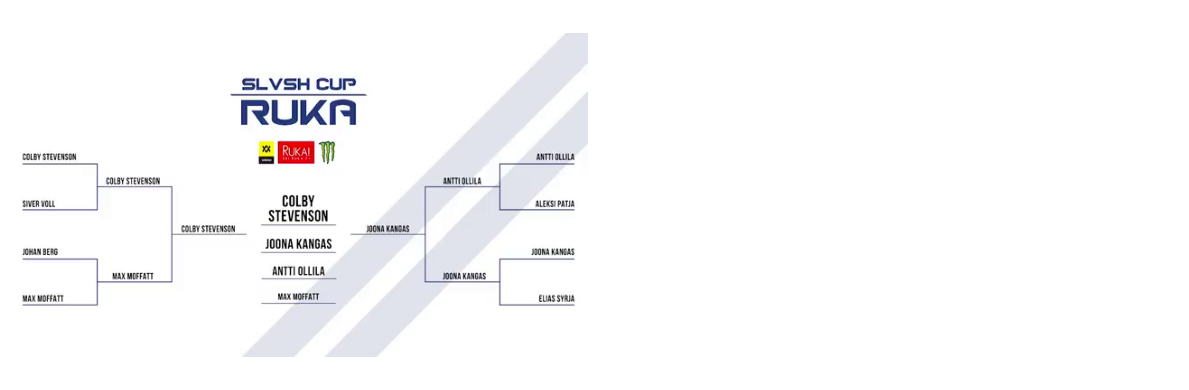

予測: NBS
期待値: NB5
ケース番号: 79


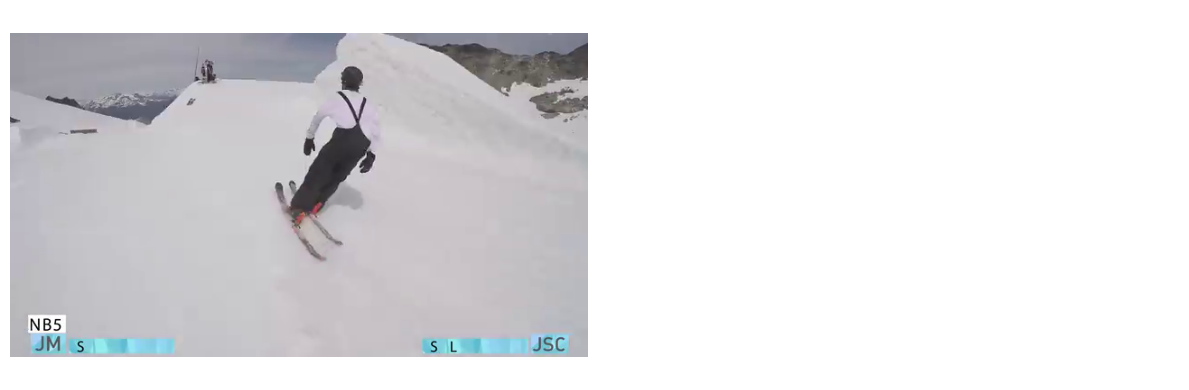

予測: WIK
期待値: 
ケース番号: 166


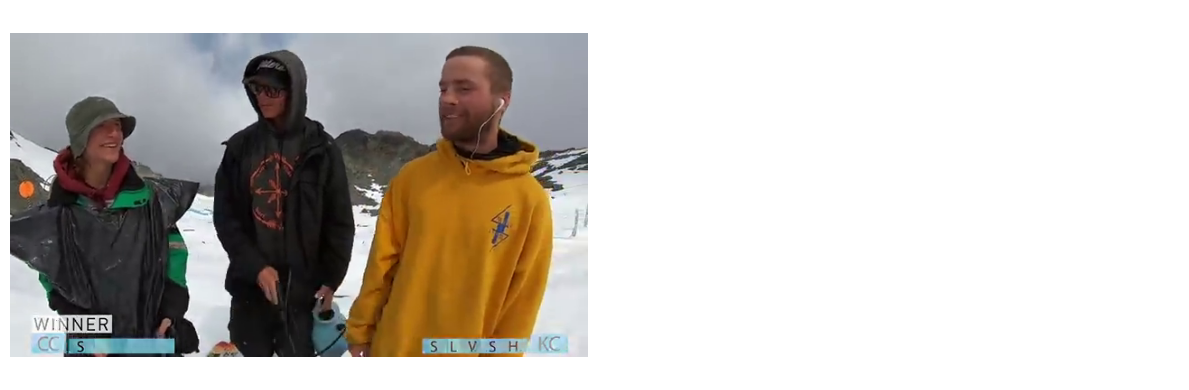

予測: SWS, BSA. B6.
期待値: SW5, B&A. B6.
ケース番号: 110


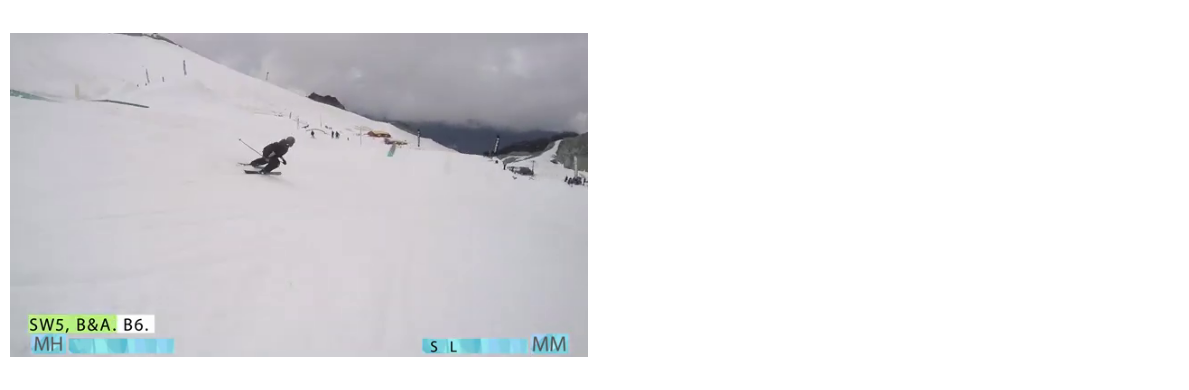

予測: PBS, OVER CLOSE
期待値: PB5, OVER CLOSE
ケース番号: 99


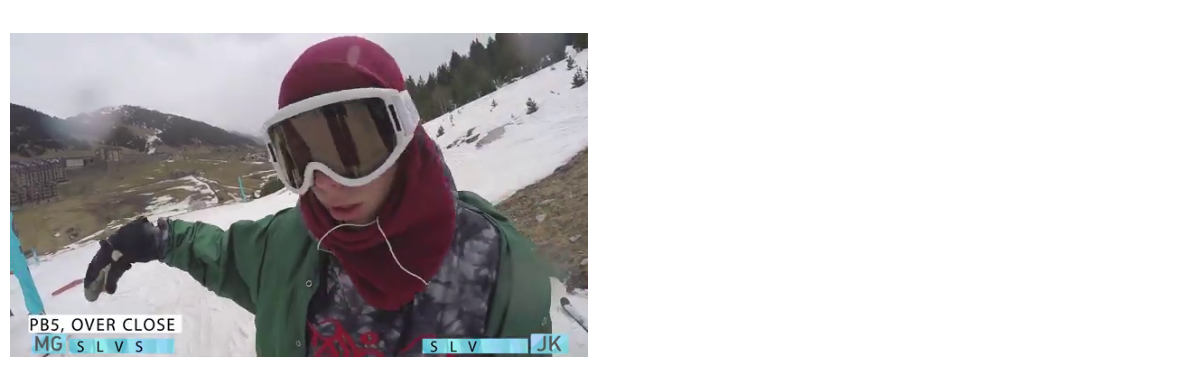

予測: UN SWS5 NOSE.
期待値: REVENGE UN SW5 NOSE.
ケース番号: 1


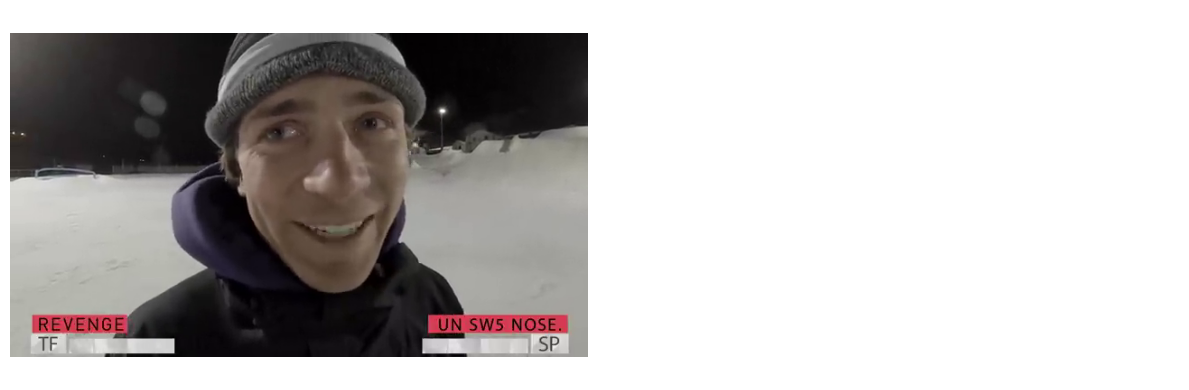

予測: BIO 6 SAFETY.
期待値: BIO 6 SAFETY
ケース番号: 127


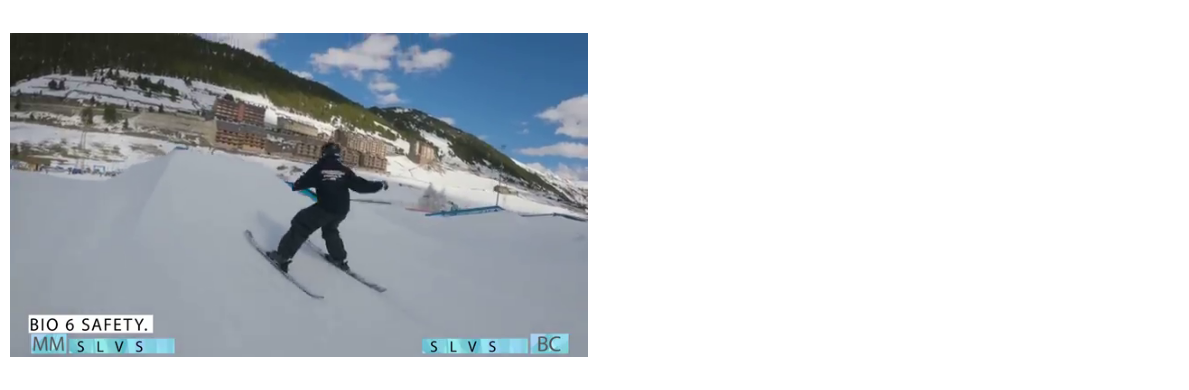

予測: BS, F2.
期待値: BS, F2
ケース番号: 67


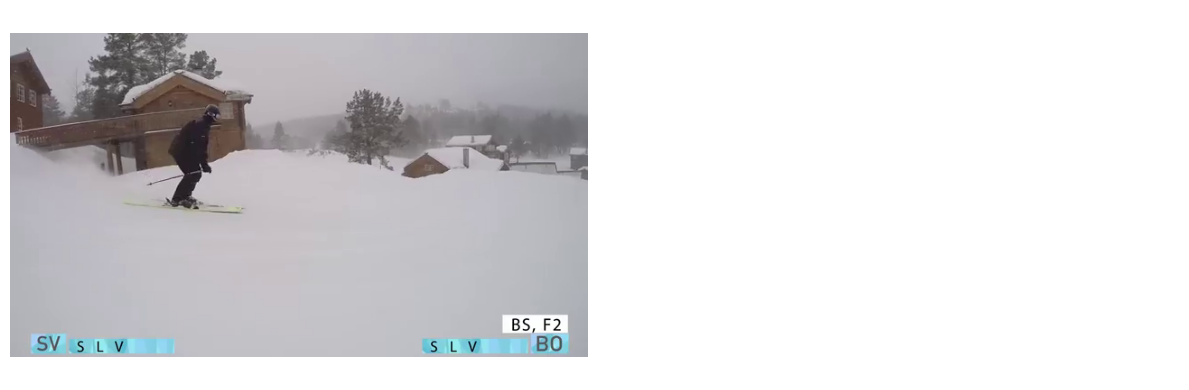

予測: TT, BIO 5S.
期待値: TT, BIO 5.
ケース番号: 75


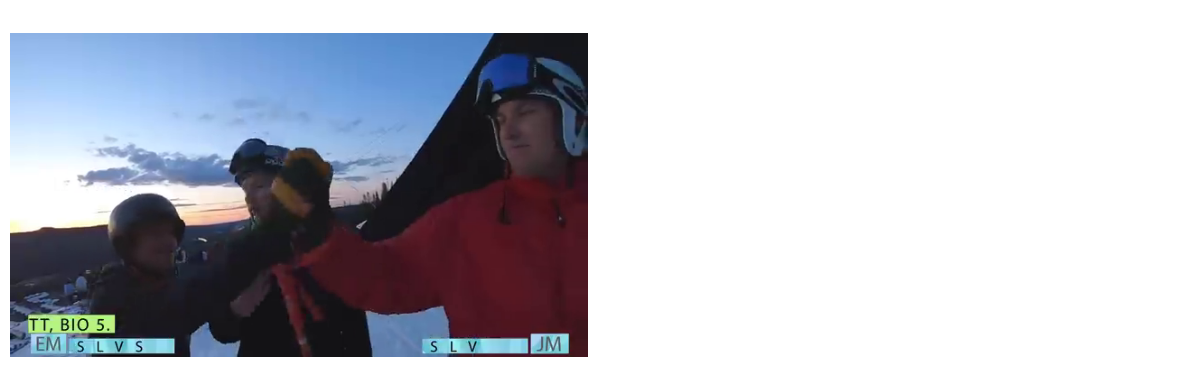

予測: BW, CORK F4.
期待値: SW, CORK F4.
ケース番号: 31


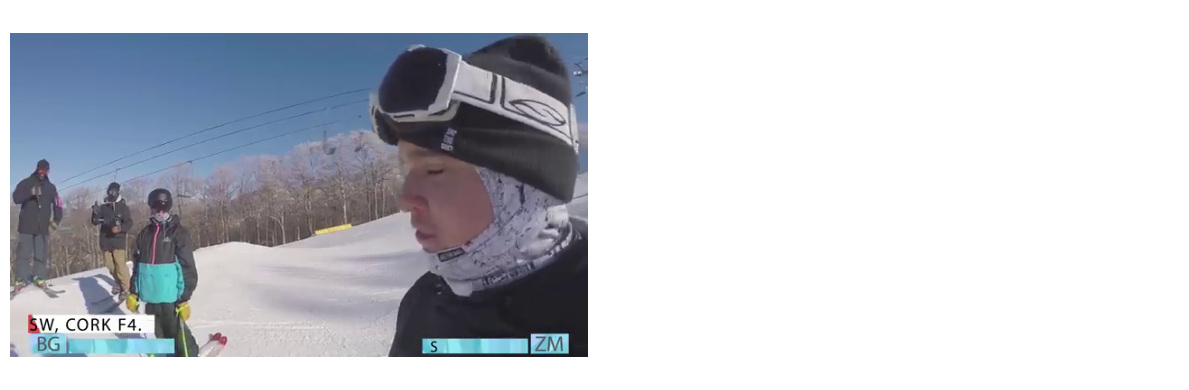

予測: L BIO 7. TAIL
期待値: L BIO 7, TAIL
ケース番号: 63


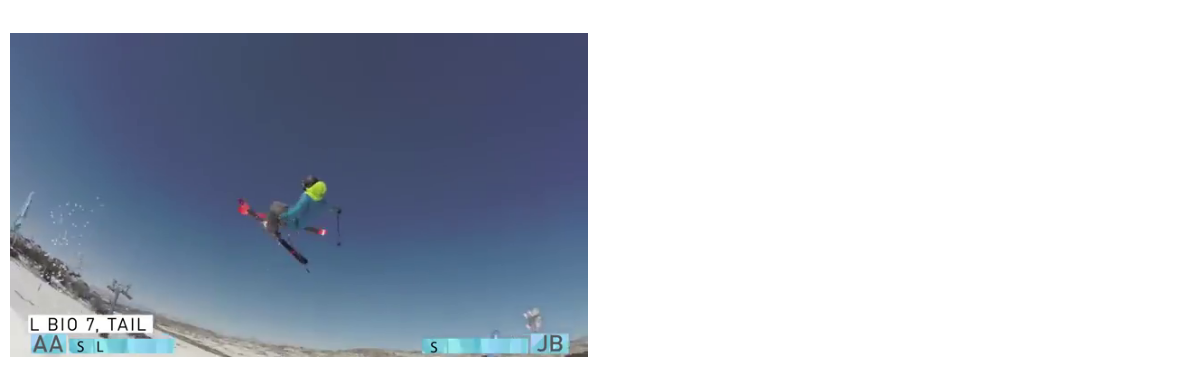

予測: BSURFACE. R4, F2.
期待値: BFURFACE. R4, F2.
ケース番号: 148


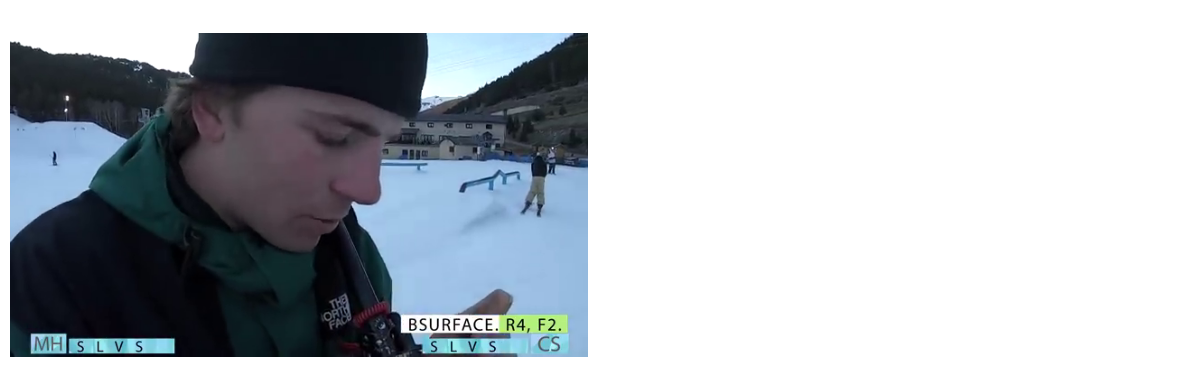

予測: SW5, TRUCK. 3, TRUCKIRODEO 7 TRUCK
期待値: SW5, TRUCK. 3, TRUCK. RODEO 7, TRUCK
ケース番号: 86


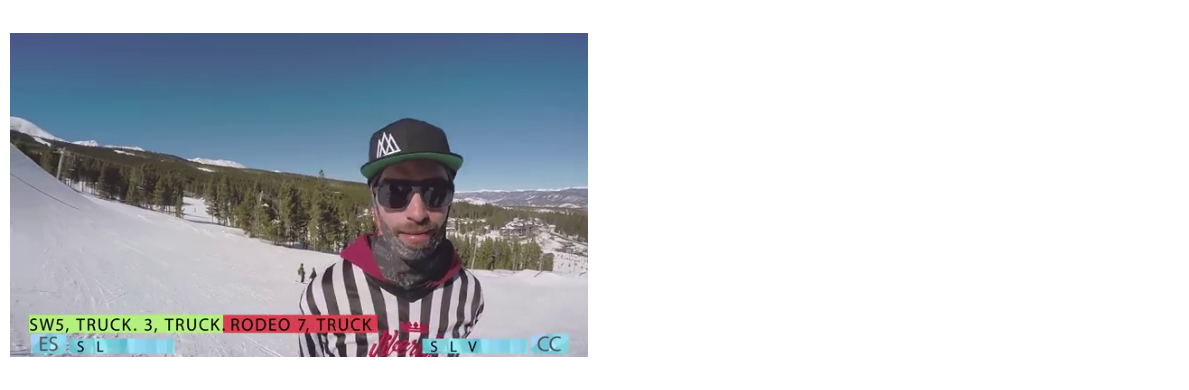

予測: SW 1, 50, 1. SW, F4.
期待値: SW 1, 50 1. SW, F4.
ケース番号: 130


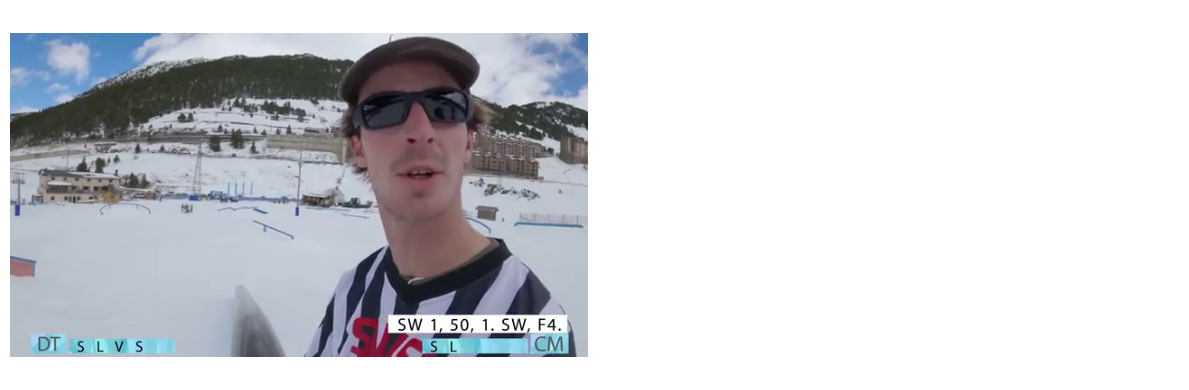

予測: LIP TAP. TRANNY, 5050. 1, SW3.
期待値: LIP TAP. TRANNY, 5050. 1, SW 3.
ケース番号: 167


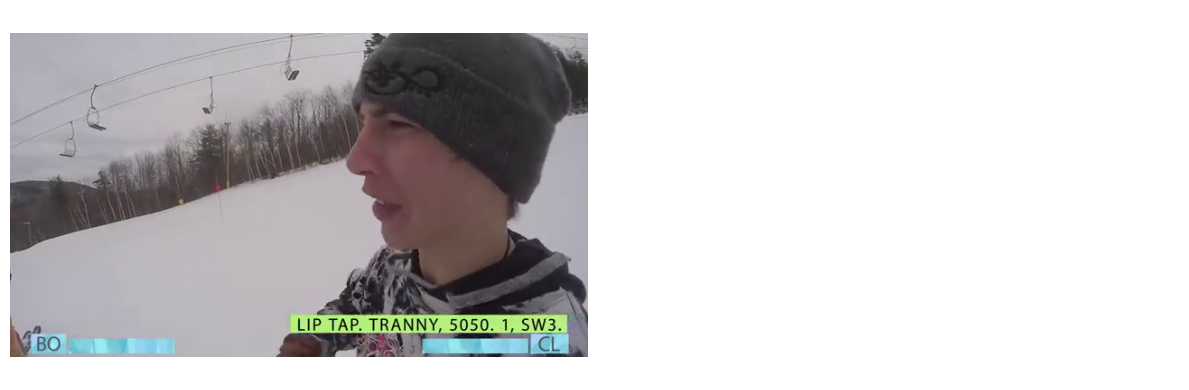

予測: SWLS, LEAD TAIL. L9, LEAD SAFETY, TWEAK.
期待値: SWL5, LEAD TAIL. L9, LEAD SAFETY, TWEAK.
ケース番号: 12


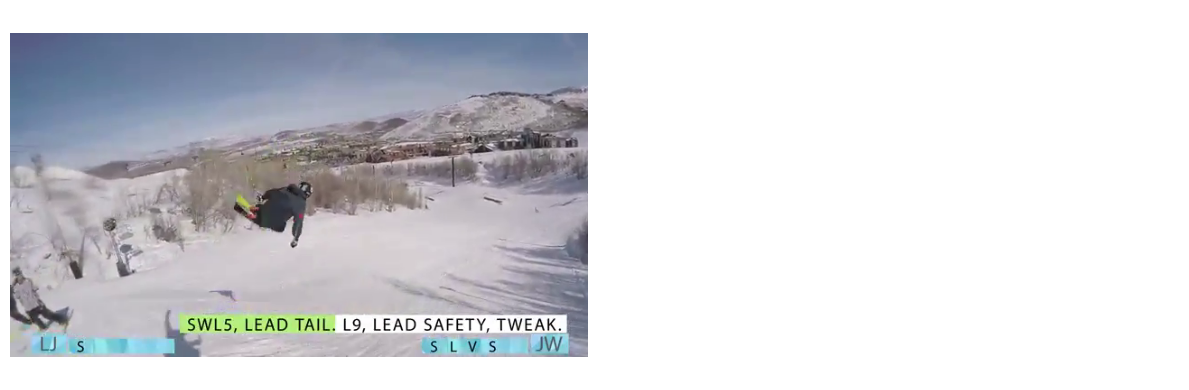

予測: CORK 7, LIU KANG. 2. HIP. BS.
期待値: CORK 7, LIE KANG. 2. HIP. BS.
ケース番号: 42


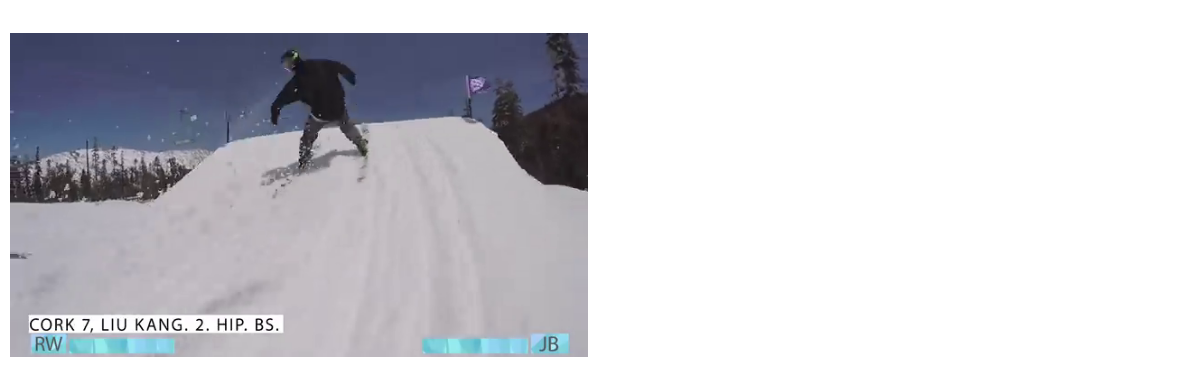

予測: , LIP, BSLIDE, SW. SW4, F2. SW1.
期待値: LIP, BSLIDE, SW. SW4, F2. SW1.
ケース番号: 177


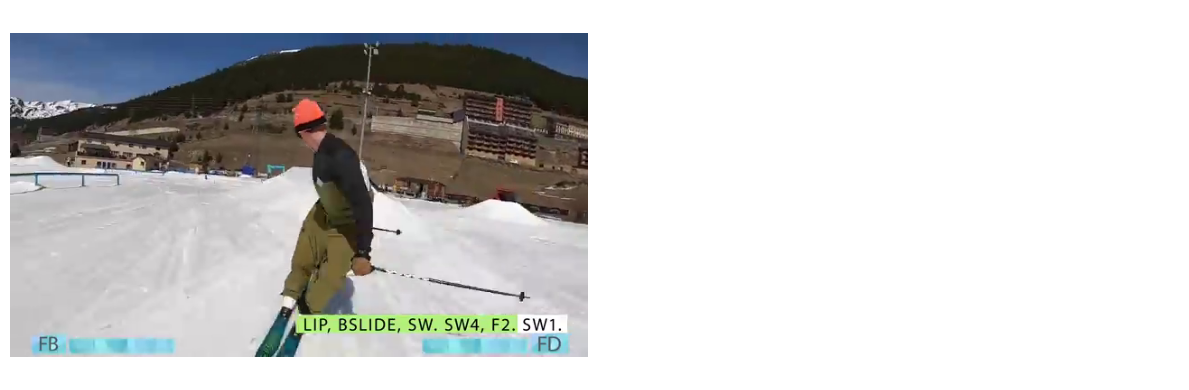

予測: B3S, FWD. FS, BS, F2. SW, B4..
期待値: B3S, FWD. FS, BS, F2. SW, B4.
ケース番号: 70


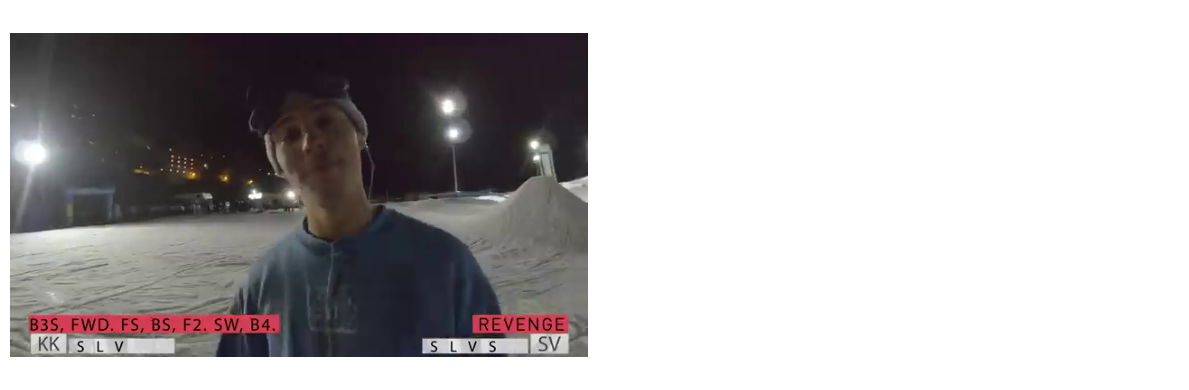

予測: 2, B2. DISASTER. UN2. SW.SWUN 5, BLUNT. 9, BLUNT.
期待値: 2, B2. DISASTER. UN2, SW. SWUN 5, BLUNT. 9, BLUNT.
ケース番号: 32


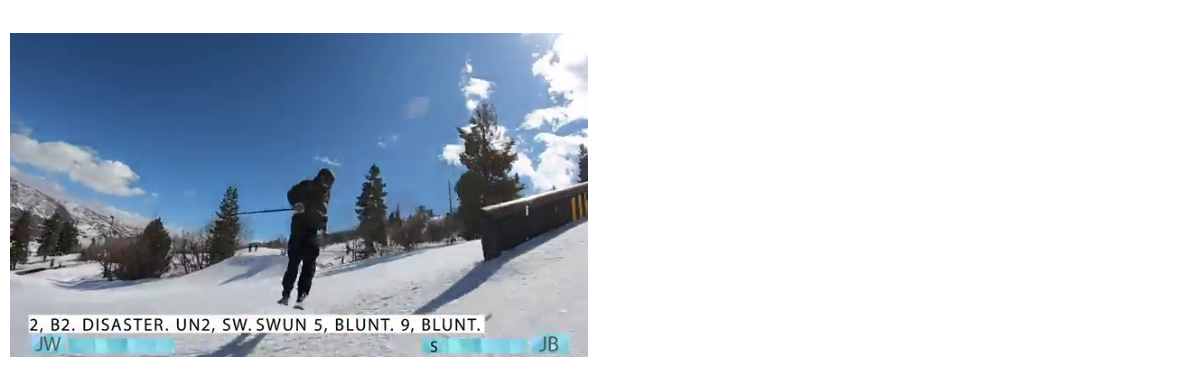

In [6]:
# precisionが低い順にソートし、上位5件を取得
low_precision_samples = df.sort_values(by='precision').head(20)

for _, row in low_precision_samples.iterrows():
    # 画像の読み込み
    image = cv2.imread(row['image_path'])
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 画像、予測、期待値を表示
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.axis('off')
    print(f'予測: {row["prediction"]}')
    print(f'期待値: {row["expected"]}')
    print(f'ケース番号: {row["case_number"]}')

    plt.tight_layout()
    plt.show()

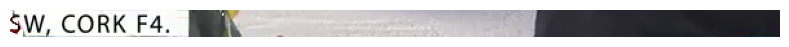

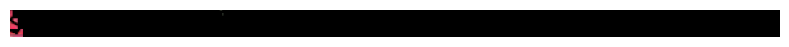

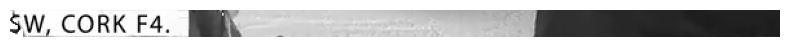

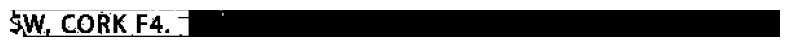

テキスト領域: (0, 0, 138, 21)


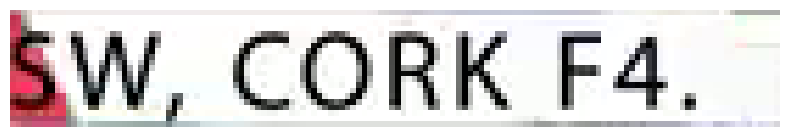

'BW, CORK F4.'

In [8]:
from slvsh_tr import Recognizer
import cv2
import pytesseract
import numpy as np

def display_image(image: cv2.typing.MatLike):
    height, width = image.shape[:2]
    plt.figure(figsize=(10, 10 / width * height))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

class TesseractFindRectWhitning4Recognizer(Recognizer):
    def __init__(self, debug: bool = False):
        self.debug = debug

    def whiten_red_and_green(self, image: cv2.typing.MatLike) -> cv2.typing.MatLike:
        # BGRからHSV色空間に変換
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # 緑色の範囲を定義（HSV色空間）
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])
        
        # 赤色の範囲を定義（HSV色空間）- 明るい赤のみ
        lower_red2 = np.array([170, 100, 100])
        upper_red2 = np.array([180, 255, 255])
        
        # マスクの作成
        mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
        mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
        mask = cv2.bitwise_or(mask_green, mask_red2)
        # 結果画像の作成
        result = image.copy()
        result[mask > 0] = [255, 255, 255]
        
        if self.debug:
            display_image(result)
            # マスクされた領域を可視化
            masked_image = cv2.bitwise_and(image, image, mask=mask)
            display_image(masked_image)
        
        return result

    def find_text_region(self, image: cv2.typing.MatLike) -> tuple:
        height, width = image.shape[:2]
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
        
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if self.debug:
            display_image(gray)
            display_image(binary)
        
        text_regions = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w > width * 0.05 and h > height * 0.9:
                # 右端または左端にアラインされているか確認
                if x < width * 0.05 or x + w > width * 0.95:
                    text_regions.append((x, y, w, h))
        
        if text_regions:
            # 幅が最大のものを選択
            return max(text_regions, key=lambda r: r[2])
        
        return None

    def infer(self, image: cv2.typing.MatLike) -> str:
        height, width = image.shape[:2]
        roi = image[int(height * 0.87):int(height * 0.93), int(width * 0.035):int(width * 0.965)]
        
        original_roi = roi.copy()
        roi = self.whiten_red_and_green(roi)
        
        text_region = self.find_text_region(roi)
        config='--psm 7 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,. /"'

        if self.debug:
            print(f"テキスト領域: {text_region}")

        if text_region is None:
            return ""
        else:
            x, y, w, h = text_region
            target_image = original_roi[y:y+h, x:x+w]

        extracted_text = pytesseract.image_to_string(target_image, config=config).strip()

        if self.debug:
            display_image(target_image)

        return extracted_text

model = TesseractFindRectWhitning4Recognizer(debug=True)
model.infer(examples[30].get_image())